In [1]:
#using Pkg
#Pkg.add("JSON")

In [2]:
using JSON

In [3]:
# カレントフォルダにある拡張子が「txt」のファイル名の一覧
files = filter(f -> isfile(f)&&occursin(r".txt$", f), readdir("."))
# 複数回に分けられて取得したjsonデータをマージする
urls = []     # 記事の重複判定用
merged = []   # 重複を覗いた記事
days = Dict{String, Int}()
categories = Dict{String, Int}()
for file in files
    data = JSON.parsefile(file)
    for d in data
        url = d["url"]
        if !(url in urls)
            push!(merged, d)
            day = split(d["datetime"])[1]
            days[day] = get(days, day, 0) + 1
            category = d["category"]
            categories[category] = get(categories, category, 0) + 1
            push!(urls, url)
        end
    end
end

In [4]:
length(merged)

736

In [5]:
# 発信日ごとの記事数
days

Dict{String, Int64} with 13 entries:
  "6/28(火… => 86
  "7/2(土)" => 71
  "7/1(金)" => 83
  "6/26(日… => 65
  "6/25(土… => 73
  "6/27(月… => 81
  "6/29(水… => 94
  "6/22(水… => 10
  "6/24(金… => 72
  "6/21(火… => 2
  "6/30(木… => 90
  "7/3(日)" => 2
  "6/23(木… => 7

In [6]:
# カテゴリごとの記事数
categories

Dict{String, Int64} with 8 entries:
  "local"         => 133
  "domestic"      => 109
  "sports"        => 102
  "entertainment" => 101
  "science"       => 51
  "it"            => 50
  "world"         => 87
  "business"      => 103

In [7]:
# マージされた記事を保存
filename = "yahoo_merged.txt"
open(filename, "w") do f
    println(f, json(merged))
end

In [8]:
# 記事からテキストデータを抽出し、形態素解析できるように加工する
#   ・句点で改行させ、不要な空白・空行を除去
function getlines(json_data)
    new_lines = []
    for j in json_data
        # 形態素解析に長文を渡したり、不要な呼び出しをしないように、文字列を調整
        ## 句点「。」の後で分割する
        line = j["detail"]
        slines = split(replace(line, r"。" => "。\n"), "\n")
        for ll in slines
            ## 行頭の空白文字列を削除
            ll = replace(ll, r"^[　 ]+" => "")
            ## 空行は削除
            if length(ll) == 0
                continue
            end
            # 処理済み文字列を格納
            push!(new_lines, ll)
        end
    end
    new_lines
end

getlines (generic function with 1 method)

In [9]:
using Awabi

function countmorph(lines)
    # 形態素解析器の設定
    ## Linux / Mac
    #tokenizer = Tokenizer()
    ## Windows：
    #dic = Dict("dicdir" => "C:\\Program Files (x86)\\MeCab\\dic\\ipadic")
    #tokenizer = Tokenizer(dic)
    ## SageMaker Studio Lab
    rcfile = "/home/studio-lab-user/mecab/etc/mecabrc"
    tokenizer = Tokenizer(rcfile)

    # 数え上げ格納領域
    word_counts = Dict{String, Int}()

    # 形態素解析＆数え上げ
    for line in lines
        # 1文を形態素解析
        tokens = tokenize(tokenizer, line)
        new_tokens = []
        for token in tokens
            attr = split(token[2], ",")
            hinsi = attr[1]
            surface = token[1] # 表記
            basic = (attr[7] != "*") ? attr[7] : surface   # 形態素の基本形
            ## 
            if hinsi in ["名詞", "動詞", "形容詞"] 
                push!(new_tokens, basic)
            end
        end
        # 形態素数を数え上げ
        for surface in new_tokens
            word_counts[surface] = get(word_counts, surface, 0) + 1
        end
    end
    word_counts
end

countmorph (generic function with 1 method)

In [10]:
lines = getlines(merged)
word_counts = countmorph(lines)

ordered_count = [c for (w,c) in sort(collect(word_counts), rev = true, by =x -> x[2]) ]

15825-element Vector{Int64}:
 6490
 2797
 1591
 1493
 1258
 1188
  972
  941
  891
  802
  751
  737
  663
    ⋮
    1
    1
    1
    1
    1
    1
    1
    1
    1
    1
    1
    1

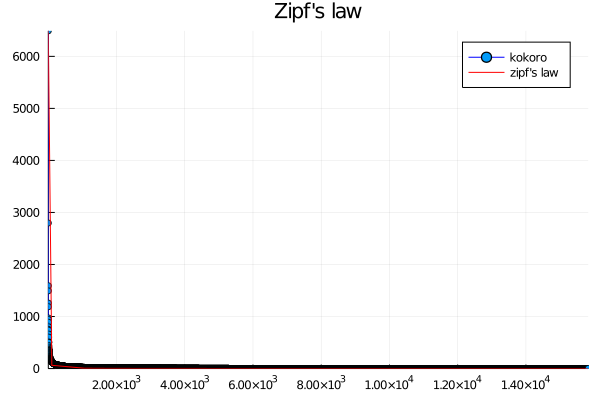

In [11]:
# ex1:何も考えずに全部表示
using Plots
base = ordered_count[1]
y_limit = base
p1 = plot(ordered_count, title="Zipf's law", markershape=:circle, linecolor=:blue, ylims=(0,y_limit), xlims=(1,length(ordered_count)), label="kokoro")
plot!(p1, x->base/x, linecolor=:red, label="zipf's law", format=:png)

In [12]:
# 保存
savefig(p1, "zipfslaw_yahoo1.png")

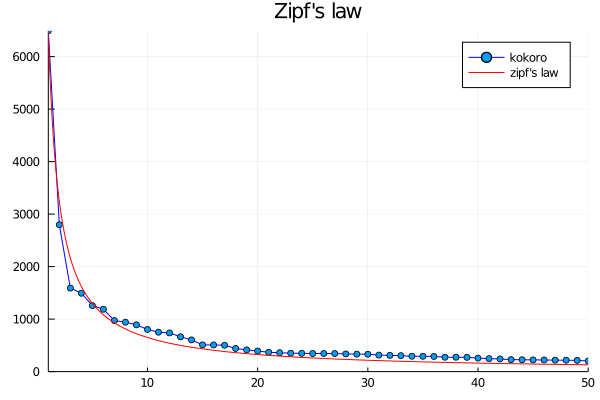

In [13]:
# ex2:上位50件を表示
using Plots
base = ordered_count[1]
y_limit = base
p2 = plot(ordered_count[1:50], title="Zipf's law", markershape=:circle, linecolor=:blue, ylims=(0,y_limit), xlims=(1,50), label="kokoro")
plot!(p2, x->base/x, linecolor=:red, label="zipf's law", format=:png)

In [14]:
# 保存
savefig(p2, "zipfslaw_yahoo2.png")

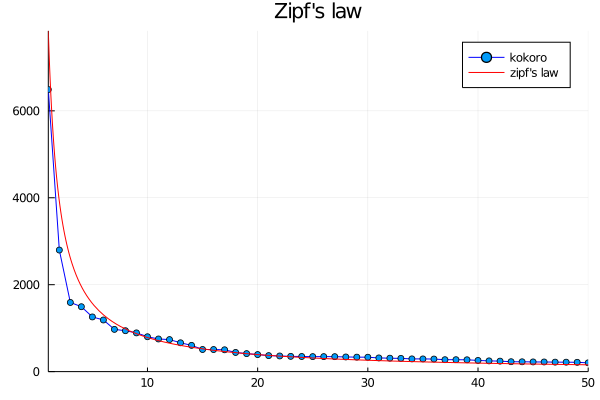

In [15]:
# ex3:20番目の値から基準を調整
using Plots
base = ordered_count[20] * 20
y_limit = base
p3 = plot(ordered_count[1:50], title="Zipf's law", markershape=:circle, linecolor=:blue, ylims=(0,y_limit), xlims=(1,50), label="kokoro")
plot!(p3, x->base/x, linecolor=:red, label="zipf's law", format=:png)

In [16]:
# 保存
savefig(p3, "zipfslaw_yahoo3.png")